In [2]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from scipy.interpolate import make_interp_spline
import pylab

In [3]:
# Time & Sample

Ts = .1
T_start = 0.0
T_end = 20.0

# Number of samples
sample_range = np.linspace(T_start,T_end,int(T_end/Ts))
T_len = len(sample_range)



In [4]:
# Initial Variables

# Noise
signoise = 1

XH = 0
XDH = 0

# Omega
omega = .1

# Amplitude
amp = 1

x_list = [omega,amp]
x0 = np.asarray(x_list)[np.newaxis]
x0 = np.transpose(x0)
xhat = x0
xhat_ukf = xhat
x_post = x0

# Length
n = len(x0)

x_post_alt = np.ones((T_len,2))
x_post_alt[0,0:2] = x0.T



In [5]:
# Setup steady-state matrices

# Noise
R = signoise ** 2
# rmat = np.eye(2) * (signoise ** 2)
# rmat = signoise

# Covariance
# P = np.diag((99999999999, 99999999999))
P = np.diag((1,1))
# P = np.zeros((2,2))

# Process Noise
phis = 1
Q0 = np.array([[(Ts**3)/3, (Ts**2)/2],[(Ts**2)/2, Ts]])
Q = phis * Q0

# System Matrix - State
phi = np.array([[np.cos(omega*Ts), np.sin(omega*Ts)/omega],[-omega*np.sin(omega*Ts), np.cos(omega*Ts)]])

# System Matrix - Input

# Measurment matrix
H = np.array([1,0])



In [6]:
# UKF weights
# W = np.ones((2*n,1)) / (2*n)
W = 1/(2*n)


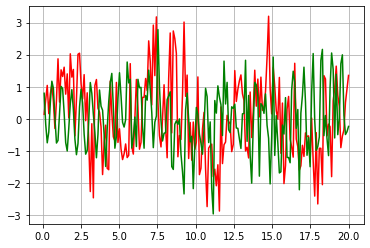

In [7]:
# Run Kalman filter

# Initialize variables

x11 = []
x_org = []
x_dot = []
xh_1 = []
xdh_1 = []
res_0 = []
IDN = np.eye(2)
samp_range = []
x_err_x = []
x_err_x_dot = []
phi_mat_x = []
phi_mat_x_dot = []

y = np.zeros((T_len,1))
x = np.zeros((T_len,2))
x[0,:] = x0.T

yy = []
yy1 = []

for b in range(0,1):
    
    for i in range(1,len(sample_range)):
        
#         for _ in range(0,500):
#         nse = np.random.normal(0, x_post_alt[0,1])
#         nse = np.random.normal(0,np.sin(xhat_ukf[0])) + np.random.normal(0, xhat_ukf[1])

        nse = np.random.normal(0,np.sin(xhat_ukf[0])) + np.random.normal(0, xhat_ukf[1])
        
        # Setup plots with noise
        X = xhat_ukf[1]*np.sin(xhat_ukf[0]*i)
#         X = (xhat_ukf[1]+np.random.normal(xhat_ukf[1])) * (np.sin(xhat_ukf[0]*i) + (np.random.normal(np.sin(xhat_ukf[0]*i))))

        x_org.append(X)    
        XD = xhat_ukf[1]*xhat_ukf[0]*np.cos(xhat_ukf[0]*i)
        x_dot.append(XD) 
        XS = X + nse
#             x11.append(XS)
        x11.append(XS)

        # Sigma Points
        sigma = np.ones((2*n,2))
        
        # SVD
        p_0 = np.dot(P,P.T)
        p_svd = np.linalg.svd(2*n*p_0)
        for j in range(0,n):
            sigma[j,:] = xhat_ukf.T +  p_svd[0::][0][j]
            sigma[n+j,:] = xhat_ukf.T - p_svd[0::][0][j]
        
        x_prior = np.zeros((n,1))
        P = P + Q 
        
        xsigma_prior = np.zeros((2*n,n))
        for m in range(0,2*n):
            xx = sigma[m,:]
            x_nxt = np.asarray(np.zeros((n,1)))
            for _ in range(0,500):
                x_nxt[0] = xx[0] + Ts*xhat_ukf[1]*np.sin(xhat_ukf[0]*i)
                x_nxt[1] = xx[1] + Ts*xhat_ukf[1]*xhat_ukf[0]*np.cos(xhat_ukf[0]*i)
                
            xsigma_prior[m,:] = np.asarray(x_nxt.T)
            x_prior = x_prior + (xsigma_prior[m,:]/(2*n)).reshape(n,1)
        
        for m in range(0,2*n):
            error = xsigma_prior[m,:] - x_prior
            P = P + np.dot(error,error.T)/(2*n)
            
#         P = (P + P.T)/(2*n)
        P = np.dot(P,P.T)/(2*n)
        
        # System Evolution
        x_nxt = np.ones((n,1))
        xx = x[i-1,:]
        x_nxt = np.asarray(np.zeros((n,1)))
        for _ in range(0,500):
            x_nxt[0] = xx[0] + Ts*x_prior[1]*np.sin(x_prior[0]*i)
            x_nxt[1] = xx[1] + Ts*x_prior[1]*x_prior[0]*np.cos(x_prior[0]*i)
            
        x[i,:] = x_nxt.T
        XS = x
        
        # Measurement update
        y[i] = x_prior[1]*np.cos(x_prior[0]*i) 
    
        # Sigma Points
#         sigma = np.ones((2*n,2))
        
        # SVD
        x_sigma_prior= np.zeros((2*n,n))
        p_0 = np.dot(P,P.T)
        p_svd = np.linalg.svd(2*n*p_0)
        for j in range(0,n):
            x_sigma_prior[j,:] = x_prior.T +  p_svd[0::][0][j]
            x_sigma_prior[n+j,:] = x_prior.T - p_svd[0::][0][j]
            
        y_avg = 0
        y_sigma = np.zeros((2*n,1))
        for m in range(0,2*n):
            y_sigma[m] = x_prior[1]*np.cos(x_prior[0]*(x_sigma_prior[m,b])) + np.sqrt(0)*np.random.randn() 
            y_avg = y_avg + W*(y_sigma[m]/(2*n))
            
        Py = R*W
        Pxy = np.zeros((n,1))
        for m in range(0,2*n):
            y_error = (y_sigma[m] - y_avg)
            x_error = (x_sigma_prior[m,:] - x_prior)
            Py = (Py + np.dot(y_error,y_error.T)/(2*n))
            Pxy = (Pxy + np.multiply(x_error,y_error.T)/(2*n))*W
            
# x_sigma_prior[m][0]

        Py = (Py + Py.T)/(2*n)
        
        # Calculate Kalman Gain
        K = Pxy/Py
        innov = y[i] - y_avg
    #     print(innov)
    # np.multiply(K,innov)
        x_post= (np.multiply(np.diag(K),innov).reshape(n,1) + x_prior.T)/(2*n)
#         x_post_vel.append(x_post[:,1])
        P = P - np.dot(K, np.dot(Py, K.T))
        x_post_alt[i,b] = np.sum(x_post[1,:])
        # Output
#         nse_omega = np.random.normal(0,np.sin(x_post_alt[0]))*np.std(x11) + np.mean(x11)
#         nse_amp = np.random.normal(0,x_post_alt[1])*np.std(x11) + np.mean(x11)
#         nse_2 = nse_omega + nse_amp
        
        nse_omega = np.random.normal(0,np.sin(x_post_alt[0]))*(np.var(x11)**2)
        nse_amp = np.random.normal(0,x_post_alt[1])*(np.var(x11)**2)
        nse_2 = nse_omega + nse_amp
        
        y0 = x_post_alt[1]*np.cos(x_post_alt[0]*i) + nse_2/(2*n)
        yy.append(np.sum(y0))
#         yy1.append(np.sum(yy[0]))

#         # Update 
#         phi_0 = np.dot(phi,XH)
#         phi_1 = phi_0[:,0] + K*RES
#         # Add value to list
#         phi_mat_x.append(phi_1[0])
                
        
#         # Track samples
#         samp_range.append(sample_range[i])
        
#         # Create Plots
#         # Figure 1
#         plt.figure(1)
# #         plt.plot(samp_range, x_org, linestyle = ":")
#         plt.plot(samp_range,phi_mat_x) 
        
        
#         # Residuals
#         RES = XS-(XH*np.cos(omega*Ts))-((np.sin(omega*Ts)*XDH)/omega) 
        
#         # Solve for position
#         XH = np.cos(omega*Ts)*XH + (XDH*(np.sin(omega*Ts)/omega)) + K[0]*RES
#         xh_1.append(XH)   

# print(x_post)
# print(x_post_alt[:,0])
        
plt.figure(2)
plt.plot(sample_range[1:T_len],x11, color = 'red')
plt.plot(sample_range[1:T_len], yy[0:], color = 'green')
# plt.plot(yy)
plt.ticklabel_format(useOffset=False)
plt.grid()


# print(x_prior)
# print(x_post)
# print(x_post_alt)
# print(np.sum(y0))
# print(np.sum(yy[0]))
# print(yy1)
# print(yy)
# print(len(x11))

# print(np.mean(x11))

# print(nse_omega)
# print(nse_amp)

# print(Pxy)

In [8]:
# # error_00 = np.array(yy[0:]).reshape(T_len-1,1) - np.array(x11)
# error_00 = np.sum(yy[0:]) - np.array(x11)
# # error_00

# # plt.figure(1)
# # plt.plot(sample_range[1:T_len],error_00)
# # plt.grid()

# # print(error_00)
# aas = np.sum(np.array(yy[0:])) - np.array(x11)
# # plt.figure(2)
# # plt.plot(aas)
# aay = np.array(yy)[0:] - np.array(x11)
# # aay[4]
# len(aay)
# # plt.plot(aay[0])

# yy_tot = []
# err_tot = []
# for i in range(0,len(x11)):
# #     yyy = np.sum(yy[i])
# #     yy_tot.append(yyy)
#     err_00 = yy[i] - x11[i]
#     err_tot.append(err_00)
    
# # err_00 = np.array(yy_tot) - np.array(x11)    
# # yyy - x11[len(x11)-1]
# # np.sum(err_00)
# # plt.plot(err_tot)
# yarr = np.array(yy)
# ry = len(yarr)
# ay = np.array(yarr) - np.array(x11)
# ay[0:][0]
# # ay_1 = yy_tot - np.array(x11)
# # err_tot
# plt.plot(sample_range[1:T_len],err_tot)
# plt.grid()
# # err_tot

In [9]:
# Calculate number of polynomials of plot

# o = 0
# oo = o + 1
# Maximum amplitude (height)
x_dot = yy[0:]
max_amp = max(x_dot)
# x_dot.index(max(x_dot))
# Index of maximum amplitude
# a00 = x_dot.count([max_amp])
# print(a00)
# # pp1 = 3


# Initialize variables
# Count position position
cnt = []
# Count velocity position
cnt1 = []
pp0 = 0
j_cnt = 0

# Count number of polynomials
# Count maximum/minimum amplitudes
for j in range(0,T_len-1):
    # If statement to find maximum(positive) amplitudes
    if x_dot[j] == max_amp:
        # Update list of amplitudes
        cnt.append(x_dot[j])
        cnt1.append(j)
    max_amp = max(x_dot[j:T_len-1])
        
# Final count
# cnt1
max_amp_cnt = len(cnt1)
# max_amp_cnt

# for j in range(0,len(sample_range[1:T_len])):
#     # If statement to find maximum(positive) amplitudes
#     if x_dot[j] == max_amp:
#         # Update list of amplitudes
#         cnt.append(x_dot[j])
#         # Index of max amplitude
# #         pp1 = x_dot.index(max_amp)
# #         pp_final = pp0 + pp1
# #         print(pp_final)
#         # Update list of max amplitude index
# #         cnt1.append(pp_final)
#         max_amp_1 = x_dot[pp0:]
#         max_amp_11 = max(max_amp_1)
#         max_amp_ind = max_amp_1.index(max(max_amp_1))
# #         max_amp_1_ind = x_dot[pp_final:].index(max_amp_1)
# #         print(max_amp_1)
# #         pp0 = pp1
# #         print(pp_final)
#         print(max_amp_ind)
# #         cnt1.append(j)
#         pp0 = j
#         j_cnt += j
#         max_amp = max(x_dot[j:])
# #         print(max_amp_1.index(max(max_amp_1)))
#         cnt1.append(max_amp_1.index(max(max_amp_1)))
# #         ass = np.argmax(x_dot[j:])
    
#         j = pp_final

# aac = x_dot[100:].index(np.max(x_dot[100:]))
# aac
# cnt1
# ass
# j_cnt
# pp_final
# x_dot
# max_amp_1_ind
# len(max_amp_1)


# # Determine indices of max amplitudes
# # Initialize counter
# max_amp_cnt = 0
# for k in range(1,len(cnt1)):
#     amp_cnt = cnt1[k] - cnt1[k-1]
# #     print(aw)
#     if amp_cnt <= 1:
#         break
# #     print(amp_cnt)
#     max_amp_cnt += 1


# # Run max amplitudes
# for l in range(0,max_amp_cnt):
#     print(cnt[l])

# print("phi_1: ",phi_1[0])
# print(x_err_x_dot)
# print(max_amp_cnt)
max_amp_cnt


5

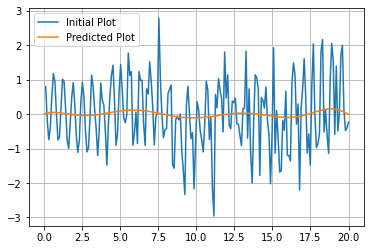

In [10]:
# Smoothen plots

# Matrix Size: Degree of Polynomial
poly_deg = max_amp_cnt * n
mat_size = int(poly_deg) + 1

# Create dummy matrix
a = np.ones((mat_size,mat_size))
b = np.zeros((mat_size,1))

#%%
# Create Input & Output arrays

# Create output values
y = np.multiply(yy[0:],W)
# for i in range(0,row_data):
#     y.append(dataset.iloc[i,7])

# Create input values
# len_Jan = len(y)
x = sample_range[1:T_len]
actual_x = x

# Normalize input array
# Mean
meanX = np.mean(x, axis=0)
# meanY = np.mean(y_Jan, axis=0)
# Standard Deviation
stdX = np.std(x, axis = 0)
x = (x- meanX) / stdX
# Variance
varX = np.var(y)

# print(x)

#%%
# Create design matrix
for i in range(0,mat_size):
    for j in range(0,mat_size):
        a[i][j] = sum(np.power(x,(i+j)))

# Create matrix
amat = np.mat(a)

# print(a)
# print(a[0][0])

# Create design output
for k in range(0, mat_size):
    b[k] = sum(np.power(x,k) * y)
# b
# sum(np.power(x,0) * np.array(y))
# type(x11)

#%%
# Calculate coefficients
# Inverse input matrix
amat_inv = np.linalg.pinv(amat)
z = amat_inv * b
# Transpose coefficient vector
zz = z.T
# Reverse index list
z3 = zz[::-1]
# print("z3: ", z3)

#%%
# Predict values

# Create list
x_list = sample_range
x = x_list
# Normalization
x = (x - meanX) / stdX

# Create dummy array
J = np.ones((len(x), 1))
cost = np.ones((len(x),1))
vec_out = np.ones((mat_size, 1))
# Solve for predicted values
for q in (range(len(x))):
    for p in range(0, mat_size):
        vec_out[p] = x[q] ** p
    # Algebraic vector
    vec_out = np.matrix(vec_out)
    # Matrix multiplication
    l = np.matmul(z3,vec_out)
    J[q] = l
    # Cost Function
    cost[q] = (1/(2 * len(x))) * np.sum(np.square(J[q] - vec_out))

    
# Actual & Predicted values
plot1 = plt.figure(1)
plt.plot(actual_x, x_dot)
plt.plot(x_list, J)
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.grid()

In [11]:
# Calculate number of polynomials of plot

# o = 0
# oo = o + 1
# Maximum amplitude (height)
x_dot = x11
max_amp = max(x_dot)
# x_dot.index(max(x_dot))
# Index of maximum amplitude
# a00 = x_dot.count([max_amp])
# print(a00)
# # pp1 = 3


# Initialize variables
# Count position position
cnt = []
# Count velocity position
cnt1 = []
pp0 = 0
j_cnt = 0

# Count number of polynomials
# Count maximum/minimum amplitudes
for j in range(0,T_len-1):
    # If statement to find maximum(positive) amplitudes
    if x_dot[j] == max_amp:
        # Update list of amplitudes
        cnt.append(x_dot[j])
        cnt1.append(j)
    max_amp = max(x_dot[j:T_len-1])
        
# Final count
# cnt1
max_amp_cnt_x11 = len(cnt1)
# max_amp_cnt

# for j in range(0,len(sample_range[1:T_len])):
#     # If statement to find maximum(positive) amplitudes
#     if x_dot[j] == max_amp:
#         # Update list of amplitudes
#         cnt.append(x_dot[j])
#         # Index of max amplitude
# #         pp1 = x_dot.index(max_amp)
# #         pp_final = pp0 + pp1
# #         print(pp_final)
#         # Update list of max amplitude index
# #         cnt1.append(pp_final)
#         max_amp_1 = x_dot[pp0:]
#         max_amp_11 = max(max_amp_1)
#         max_amp_ind = max_amp_1.index(max(max_amp_1))
# #         max_amp_1_ind = x_dot[pp_final:].index(max_amp_1)
# #         print(max_amp_1)
# #         pp0 = pp1
# #         print(pp_final)
#         print(max_amp_ind)
# #         cnt1.append(j)
#         pp0 = j
#         j_cnt += j
#         max_amp = max(x_dot[j:])
# #         print(max_amp_1.index(max(max_amp_1)))
#         cnt1.append(max_amp_1.index(max(max_amp_1)))
# #         ass = np.argmax(x_dot[j:])
    
#         j = pp_final

# aac = x_dot[100:].index(np.max(x_dot[100:]))
# aac
# cnt1
# ass
# j_cnt
# pp_final
# x_dot
# max_amp_1_ind
# len(max_amp_1)


# # Determine indices of max amplitudes
# # Initialize counter
# max_amp_cnt = 0
# for k in range(1,len(cnt1)):
#     amp_cnt = cnt1[k] - cnt1[k-1]
# #     print(aw)
#     if amp_cnt <= 1:
#         break
# #     print(amp_cnt)
#     max_amp_cnt += 1


# # Run max amplitudes
# for l in range(0,max_amp_cnt):
#     print(cnt[l])

# print("phi_1: ",phi_1[0])
# print(x_err_x_dot)
# print(max_amp_cnt)

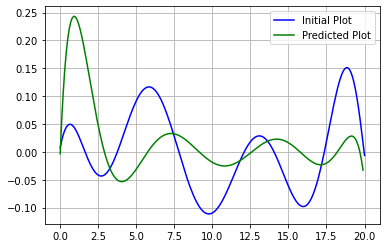

In [12]:
# Smoothen plots

# Matrix Size: Degree of Polynomial
poly_deg = max_amp_cnt_x11 * n
mat_size = int(poly_deg) + 1

# Create dummy matrix
a = np.ones((mat_size,mat_size))
b = np.ones((mat_size,1))

#%%
# Create Input & Output arrays

# Create output values
y = np.multiply(x11,W)
# for i in range(0,row_data):
#     y.append(dataset.iloc[i,7])

# Create input values
# len_Jan = len(y)
x = sample_range[0:T_len]
actual_x = x

# Normalize input array
# Mean
meanX = np.mean(x, axis=0)
# meanY = np.mean(y_Jan, axis=0)
# Standard Deviation
stdX = np.std(x, axis = 0)
x = (x- meanX) / stdX
# Variance
varX = np.var(y)

# print(x)

#%%
# Create design matrix
for i in range(0,mat_size):
    for j in range(0,mat_size):
        a[i][j] = sum(np.power(x,(i+j)))

# Create matrix
amat = np.mat(a)

# print(a)
# print(a[0][0])

# Create design output
for k in range(0, mat_size):
    b[k] = sum(np.power(x,k) * y)[mat_size]

#%%
# Calculate coefficients
# Inverse input matrix
amat_inv = np.linalg.pinv(amat)
z = amat_inv * b
# Transpose coefficient vector
zz = z.T
# Reverse index list
z3 = zz[::-1]
# print("z3: ", z3)

#%%
# Predict values

# Create list
x_list = sample_range[0:T_len-1]
x = x_list
# Normalization
x = (x - meanX) / stdX

# Create dummy array
J1 = np.ones((len(x), 1))
cost = np.ones((len(x),1))
vec_out = np.ones((mat_size, 1))
# Solve for predicted values
for q in (range(len(x))):
    for p in range(0, mat_size):
        vec_out[p] = x[q] ** p
    # Algebraic vector
    vec_out = np.matrix(vec_out)
    # Matrix multiplication
    l = np.matmul(z3,vec_out)
    J1[q] = l
    # Cost Function
    cost[q] = (1/(2 * len(x))) * np.sum(np.square(J[q] - vec_out))

    
# Actual & Predicted values
plot1 = plt.figure(1)
# plt.plot(actual_x, x_dot)
plt.plot(sample_range,J, color = 'blue')
plt.plot(x_list, J1, color = 'green')
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.grid()

In [13]:
# # Run Kalman filter

# # Initialize variables

# x0 = []
# x_org = []
# x_dot = []
# xh_1 = []
# xdh_1 = []
# res_0 = []
# IDN = np.eye(2)
# samp_range = []
# x_err_x = []
# x_err_x_dot = []
# phi_mat_x = []
# phi_mat_x_dot = []
# for i in range(0,len(sample_range)):

#     # Solve for Prediciton (M)
#     # PHIP = np.dot(phi,P)
#     # PHIPPHIT = np.dot(PHIP,phi.T)
#     # M = PHIPPHIT + Q
#     M = np.dot(np.dot(phi,P),phi.T) + Q
    
#     # Solve for Kalman Gain
#     # HM = np.dot(H,M)
#     # HMHT = np.dot(HM,H.T)
#     # HMHTR = HMHT + rmat
#     S = np.dot(np.dot(H,M),H.T) + rmat
#     # print(HMHTR)
#     # HMHTRINV = 1/HMHTR[0,0]
#     # print(HMHTRINV)
#     # HH2 = np.linalg.inv(HMHTR)
#     # print(HH2)
#     HH2 = np.linalg.inv(S)
#     MHT = np.dot(M,H.T)
#     K = np.dot(MHT,HH2)
#     # Process Noise
#     # KH = np.dot(K,H)
#     IKH = IDN-np.dot(K,H)
#     P = np.dot(IKH,M)
    
#     # Setup plots with noise
#     X = amp*np.sin(omega*i)
#     x_org.append(X)    
#     XD = amp*omega*np.cos(omega*i)
#     x_dot.append(XD) 
#     XS = X + np.random.normal(0, omega)
#     x0.append(XS)
    
#     # Track samples
#     samp_range.append(sample_range[i])
#     # Plot sample (x-axis)
#     # plt.plot(samp_range, x_org, linestyle = ":")

#     # Reassign variable    
#     XHOLD = XH
    
#     # Residuals
#     RES = XS-(XH*np.cos(omega*Ts))-((np.sin(omega*Ts)*XDH)/omega)    
#     # Version 2
#     RES2 = XS - np.dot(np.dot(H,phi),XHOLD)
    
#     # Solve for position
#     XH = np.cos(omega*Ts)*XH + (XDH*(np.sin(omega*Ts)/omega)) + K[0]*RES
#     xh_1.append(XH)    
#     # plt.plot(samp_range,xh_1)
    
#     # Solve for velocity
#     XDH = (-omega*np.sin(omega*Ts)*XHOLD) + (XDH*(np.cos(omega*Ts))) + K[1]*RES
#     xdh_1.append(XDH)
#     # plt.plot(samp_range,xdh_1)
    
#     # Update 
#     phi_0 = np.dot(phi,XH)
#     phi_1 = phi_0[:,0] + K*RES
#     # Add value to list
#     phi_mat_x.append(phi_1[0])

#     # Create Plots
#     # Figure 1
#     plt.figure(1)
#     plt.plot(samp_range, x_org, linestyle = ":")
#     plt.plot(samp_range,phi_mat_x) 
#     # Alternate equation to be plotted
#     # plt.plot(samp_range,xh_1)
#     plt.grid()
#     phi_mat_x_dot.append(phi_1[1])
#     # Figure 2
#     plt.figure(2)
#     plt.plot(samp_range, x_dot, linestyle = ":")
#     plt.plot(samp_range,phi_mat_x_dot) 
#     # Alternate equation to be plotted
#     # plt.plot(samp_range,xdh_1)
#     plt.grid()
    
#     # Calculate Error
#     # Position
#     x_err_0 = (abs(phi_1[0]) - abs(X))
#     x_err_x.append(x_err_0)
#     # Velocity
#     x_err_1 = (abs(phi_1[1]) - abs(XD))
#     x_err_x_dot.append(x_err_1)    
    
# # Calculate number of polynomials of plot

# # o = 0
# # oo = o + 1
# # Maximum amplitude (height)
# max_amp = max(x_dot)
# # Index of maximum amplitude
# x_dot.count([max_amp])
# pp1 = 3
# # Initialize variables
# # Count position position
# cnt = []
# # Count velocity position
# cnt1 = []
# for j in range(0,len(sample_range)):
#     # If statement to find maximum(positive) amplitudes
#     if x_dot[j] == max_amp and j < len(sample_range)-1:
#         # Update list of amplitudes
#         cnt.append(x_dot[j])
#         # Index of max amplitude
#         pp = x_dot.index(max_amp) 
#         # Update list of max amplitude index
#         cnt1.append(pp)
#         max_amp = max(x_dot[pp+1:])

# # Determine indices of max amplitudes
# # Initialize counter
# max_amp_cnt = 0
# for k in range(1,len(cnt1)):
#     amp_cnt = cnt1[k] - cnt1[k-1]
# #     print(aw)
#     if amp_cnt <= 1:
#         break
# #     print(amp_cnt)
#     max_amp_cnt += 1


# # Run max amplitudes
# for l in range(0,max_amp_cnt):
#     print(cnt[l])

# print("phi_1: ",phi_1[0])
# # print(x_err_x_dot)

In [14]:
# # Plots
# plt.figure(1)
# plt.plot(sample_range, x_err_x)
# plt.grid()
# plt.figure(2)
# plt.plot(sample_range, x_err_x_dot)
# plt.grid()

In [15]:
# plt.plot(sample_range,phi_mat_x_dot)
# plt.grid()

In [16]:
# plt.plot(sample_range,x_org,sample_range,x0, linestyle=":")
# plt.plot(sample_range,xh_1, color='red', linestyle="--")
# print(np.dot(phi,XH))
# print(np.cos(omega*Ts)*XH + (XDH*(np.sin(omega*Ts)/omega)))
# print(phi_1[0])


In [17]:
# # Smoothen plots

# # Matrix Size: Degree of Polynomial
# poly_deg = max_amp_cnt * 3
# mat_size = poly_deg + 1

# # Create dummy matrix
# a = np.ones((mat_size,mat_size))
# b = np.ones((mat_size,1))

# #%%
# # Create Input & Output arrays

# # Create output values
# y = phi_mat_x_dot
# # for i in range(0,row_data):
# #     y.append(dataset.iloc[i,7])

# # Create input values
# # len_Jan = len(y)
# x = sample_range
# actual_x = x

# # Normalize input array
# # Mean
# meanX = np.mean(x, axis=0)
# # meanY = np.mean(y_Jan, axis=0)
# # Standard Deviation
# stdX = np.std(x, axis = 0)
# x = (x- meanX) / stdX
# # Variance
# varX = np.var(y)

# # print(x)

# #%%
# # Create design matrix
# for i in range(0,mat_size):
#     for j in range(0,mat_size):
#         a[i][j] = sum(np.power(x,(i+j)))

# # Create matrix
# amat = np.mat(a)

# # print(a)
# # print(a[0][0])

# # Create design output
# for k in range(0, mat_size):
#     b[k] = sum(np.power(x,k) * y)

# #%%
# # Calculate coefficients
# # Inverse input matrix
# amat_inv = np.linalg.pinv(amat)
# z = amat_inv * b
# # Transpose coefficient vector
# zz = z.T
# # Reverse index list
# z3 = zz[::-1]
# # print("z3: ", z3)

# #%%
# # Predict values

# # Create list
# x_list = sample_range
# x = x_list
# # Normalization
# x = (x - meanX) / stdX

# # Create dummy array
# J = np.ones((len(x), 1))
# cost = np.ones((len(x),1))
# vec_out = np.ones((mat_size, 1))
# # Solve for predicted values
# for q in (range(len(x))):
#     for p in range(0, mat_size):
#         vec_out[p] = x[q] ** p
#     # Algebraic vector
#     vec_out = np.matrix(vec_out)
#     # Matrix multiplication
#     l = np.matmul(z3,vec_out)
#     J[q] = l
#     # Cost Function
#     cost[q] = (1/(2 * len(x))) * np.sum(np.square(J[q] - vec_out))

    
# # Actual & Predicted values
# plot1 = plt.figure(1)
# plt.plot(actual_x, x_dot)
# plt.plot(x_list, J)
# plt.plot(sample_range,phi_mat_x_dot)
# # plt.plot(x_list, J_tot_smooth)
# plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
# plt.grid()

In [18]:
# # Initialize error array
# y = x_dot
# error = []
# for i in range(0,len(J)):
#     pred_error = J[i]
#     actual_error = y[i]
#     err = pred_error - actual_error
#     error.append(err)
    
# # Error plot
# plot3 = plt.figure(3)
# plt.plot(sample_range,error)
# plt.grid()


In [19]:
# # Plot using spline function from scilearn library
# x_new = np.linspace(T_start,T_end, 300)
# a_BSpline = make_interp_spline(sample_range, phi_mat_x_dot)
# y_new = a_BSpline(x_new)
# plt.plot(x_new, y_new)

In [20]:
# # Polynomial fit using pylab
# x = sample_range
# z = np.polyfit(sample_range, phi_mat_x_dot, 9)
# p = np.poly1d(z)
# plt.plot(sample_range, phi_mat_x_dot)
# pylab.plot(x,p(x),"r--")

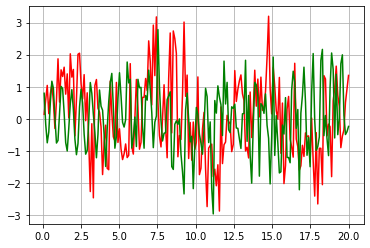

In [21]:
plt.figure(2)
plt.plot(sample_range[1:T_len],x11, color = 'red')
plt.plot(sample_range[1:T_len], yy[0:], color = 'green')
# plt.plot(yy)
plt.ticklabel_format(useOffset=False)
plt.grid()

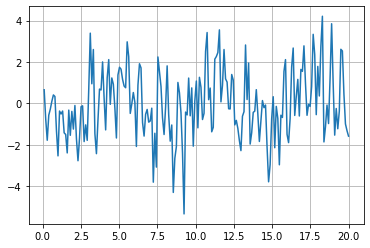

In [22]:
# error_00 = np.array(yy[0:]).reshape(T_len-1,1) - np.array(x11)
error_00 = np.sum(yy[0:]) - np.array(x11)
# error_00

# plt.figure(1)
# plt.plot(sample_range[1:T_len],error_00)
# plt.grid()

# print(error_00)
aas = np.sum(np.array(yy[0:])) - np.array(x11)
# plt.figure(2)
# plt.plot(aas)
aay = yy - np.array(x11)
# aay[4]
len(aay)
# plt.plot(aay[0])

yy_tot = []
err_tot = []
for i in range(0,len(x11)):
#     yyy = np.sum(yy[i])
#     yy_tot.append(yyy)
    err_00 = yy[i] - x11[i]
    err_tot.append(err_00)
    
# err_00 = np.array(yy_tot) - np.array(x11)    
# yyy - x11[len(x11)-1]
# np.sum(err_00)
# plt.plot(err_tot)
yarr = np.array(yy)
ry = len(yarr)
ay = np.array(yarr) - np.array(x11)
ay[0:][0]
# ay_1 = yy_tot - np.array(x11)
# err_tot
plt.plot(sample_range[1:T_len],err_tot)
plt.grid()
# err_tot

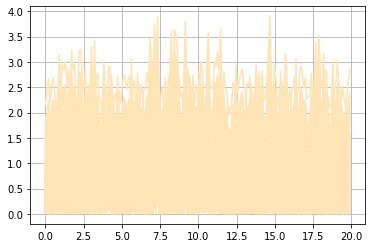

In [23]:
# Mean Absoute Error
aj = J[0:T_len-1]
plot1 = plt.figure(1)

y_arr = (yy[0:] - np.mean(yy[0:]))/np.std(yy[0:])
x11_arr = (x11 - np.mean(x11))/np.std(x11)
# plt.plot(actual_x, x_dot)
# plt.plot(sample_range,J, color = 'blue')
plt.plot(sample_range[0:T_len-1], np.power((((y_arr-x11_arr)**2)/n),0.5), color = 'moccasin')
# plt.plot(sample_range[0:T_len-1], np.square((np.array(yy[0:])-np.array(x11))**2/n), color = 'purple')
# plt.plot(sample_range[0:T_len-1], np.abs(y_arr-x11_arr)/n, color = 'aqua')
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
# plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.ticklabel_format(useOffset=False)
plt.grid()
# abcd = J1-aj
# abcd

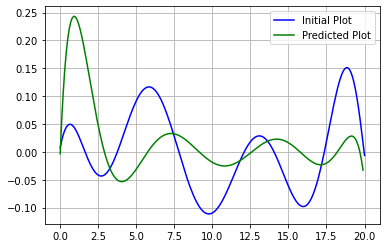

In [24]:
# Actual & Predicted values
plot1 = plt.figure(1)
# plt.plot(actual_x, x_dot)
plt.plot(sample_range,J, color = 'blue')
plt.plot(x_list, J1, color = 'green')
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.grid()

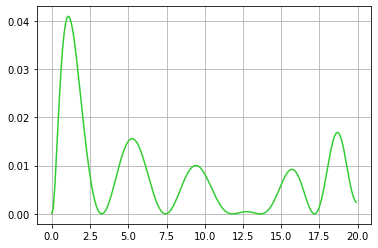

In [25]:
# Squared Error
aj = J[0:T_len-1]
plot1 = plt.figure(1)
# plt.plot(actual_x, x_dot)
# plt.plot(sample_range,J, color = 'blue')
plt.plot(sample_range[0:T_len-1], (J1-J[0:T_len-1])**2, color = 'limegreen')
# plt.plot(sample_range[0:T_len-1], np.abs(J1-J[0:T_len-1]), color = 'green')
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
# plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.grid()
# abcd = J1-aj
# abcd

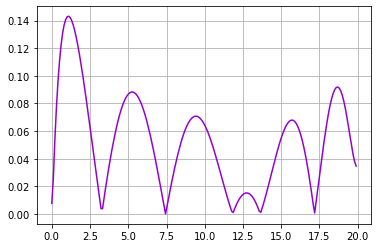

In [26]:
# RMS Error
aj = J[0:T_len-1]
plot1 = plt.figure(1)
# plt.plot(actual_x, x_dot)
# plt.plot(sample_range,J, color = 'blue')
# plt.plot(sample_range[0:T_len-1], np.power(((J1-J[0:T_len-1])**2/n),0.5), color = 'silver')
plt.plot(sample_range[0:T_len-1], np.sqrt(((J1-J[0:T_len-1])**2)/n), color = 'darkviolet')
# plt.plot(sample_range[0:T_len-1], np.abs(J1-J[0:T_len-1]), color = 'green')
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
# plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.ticklabel_format(useOffset=False)
plt.grid()
# abcd = J1-aj
# abcd

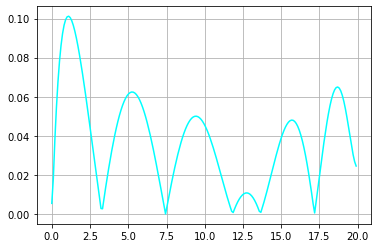

In [27]:
# Mean Absoute Error
aj = J[0:T_len-1]
plot1 = plt.figure(1)
# plt.plot(actual_x, x_dot)
# plt.plot(sample_range,J, color = 'blue')
# plt.plot(sample_range[0:T_len-1], np.square((J1-J[0:T_len-1])**2/n), color = 'purple')
plt.plot(sample_range[0:T_len-1], np.abs(J1-J[0:T_len-1])/n, color = 'aqua')
# plt.plot(sample_range,phi_mat_x_dot)
# plt.plot(x_list, J_tot_smooth)
# plt.legend(["Initial Plot", "Predicted Plot", "Predicted Trendline"])
plt.ticklabel_format(useOffset=False)
plt.grid()
# abcd = J1-aj
# abcd

In [28]:
aa = np.sqrt(((J1-J[0:T_len-1])**2)/n)
aa[-1]

array([0.03472949])

In [29]:
mean_aa = np.mean(aa)
mean_aa

0.052699737147956956